# Popularity approch
**Goal:** A study of how the popularity approval interacts with the sentiment measure in the speechs <br>
* Download a realible source of popularity data ✔️ <br>
I decided to use https://www.realclearpolitics.com/epolls/other/president_obama_job_approval-1044.html since is a compilation of various popularity polls
* Plot populatity over time vs sentiment over time 
* Plot frequency over sentiment

## Load data

In [1]:
# Libraries

from urllib import request
from pathlib import Path
from plotly.subplots import make_subplots
import json
import os
import plotly
import sys
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Basic paths
src_path = str(Path.cwd().parent / "src")
sys.path.append(src_path)

project_path = Path().resolve().parent

## Download polls and save a readable table

In [3]:
# Download the source

download_path = project_path / "sentiment_analysis"  # To change later

# Define the remote file to retrieve
remote_url = 'https://www.realclearpolitics.com/epolls/json/1044_historical.js?1653863439874&callback=return_json'
# Define the local filename to save data
local_file = download_path / 'obama-job-approval-ratings.txt'
# Download remote and save locally
request.urlretrieve(remote_url, local_file)

(PosixPath('/Users/serenekim/MDA _Project/mda-kuwait/sentiment_analysis/obama-job-approval-ratings.txt'),
 <http.client.HTTPMessage at 0x7ff4adaf37f0>)

In [4]:
# Edit the downloaded file useful table, save it and delete extra files

with open(download_path / 'obama-job-approval-ratings.txt','r') as f:
    s_temp = f.read()
    s_temp = s_temp.split("(")
    s_temp = s_temp[1:]
    s_temp = s_temp[0]
    s_temp = s_temp.split("state")
    s_temp = s_temp[0]
    s_temp = s_temp[:-14]+"}}"
    d_temp = eval(s_temp)

approve = []
disapprove = []
date = []

for i in range(len(d_temp['poll']["rcp_avg"])):
    approve.append(float(d_temp['poll']["rcp_avg"][i]["candidate"][0]["value"]))
    disapprove.append(float(d_temp['poll']["rcp_avg"][i]["candidate"][1]["value"]))
    date.append(pd.to_datetime(d_temp['poll']["rcp_avg"][i]["date"], utc=True))

df_ppl = pd.DataFrame({"date": date, "Approve": approve, "Disapprove": disapprove})
df_ppl["date"] = df_ppl["date"].dt.strftime('%Y-%m-%d')
df_ppl["date"] = pd.to_datetime(df_ppl["date"])
df_ppl = df_ppl.sort_values(by=["date"], ascending=True)
df_ppl.to_csv(download_path / 'obama-job-approval-ratings.txt', index=False)

## Open tables and treat them if necessary

In [5]:
# Open the popularity data 

df_ppl = pd.read_csv(download_path / 'obama-job-approval-ratings.txt')
df_ppl = df_ppl.sort_values("date")
df_ppl.head()

,date,Approve,Disapprove
0,2009-01-27,63.3,20.0
1,2009-01-28,63.3,20.0
2,2009-01-29,63.5,19.3
3,2009-01-30,63.5,19.3
4,2009-01-31,61.8,19.4


In [6]:
# Open the sentiment data and filter for presidential speeches

df_sa = pd.read_csv(download_path / 'results_sa_all.txt', infer_datetime_format = True, parse_dates = ["date"])

df_sa["date"] = pd.to_datetime(df_sa["date"])
df_sa = df_sa.sort_values("date")
df_sa = df_sa[df_sa["date"] >= "2009-01-27"]
df_sa.head()

,title,date,stanza,textblob,vader,subjectivity
201,Economic_Crisis_and_Executive_Compensation_Sal...,2009-02-04,-0.226,0.122,0.950,0.409
284,Lincoln_Bicentennial,2009-02-12,-0.207,0.113,0.592,0.466
47,State_of_the_Nation_2009,2009-02-24,-0.246,0.101,1.000,0.433
276,Iraq_War_Camp_Lejeune,2009-02-27,-0.028,0.170,1.000,0.438
275,Hispanic_Chamber_of_Commerce,2009-03-10,-0.132,0.174,1.000,0.464


In [7]:
# Frequency tables

df_months = pd.DataFrame(df_sa["date"])
df_months["count"] = 1
df_months = df_months.groupby((pd.Grouper(freq='M', key='date'))).sum()
df_months.head()

,count
date,
2009-02-28,4
2009-03-31,1
2009-04-30,6
2009-05-31,5
2009-06-30,5


## Plots

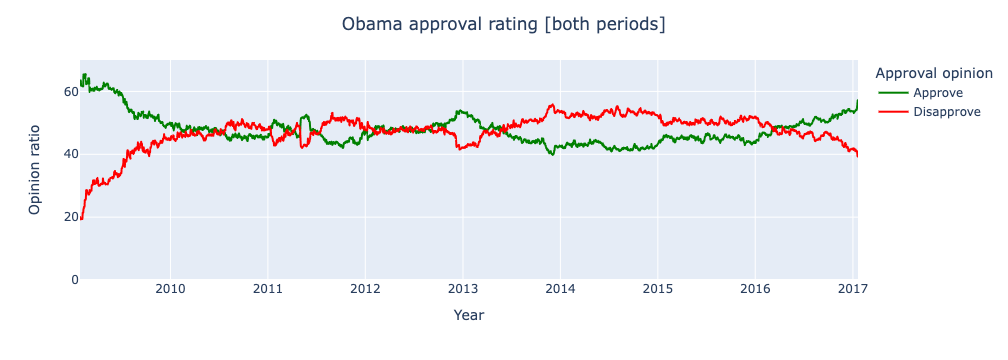

In [9]:
# Plot obama ratings

fig = px.line(df_ppl, x="date", y=["Approve","Disapprove"], 
              color_discrete_sequence=["green", "red"])
fig.update_layout(title = {"text":"Obama approval rating [both periods]", "x":0.5},
                  legend_title = "Approval opinion",
                  xaxis_title = "Year",
                  yaxis_title = "Opinion ratio",
                  yaxis_range=[0,70])

fig.show()

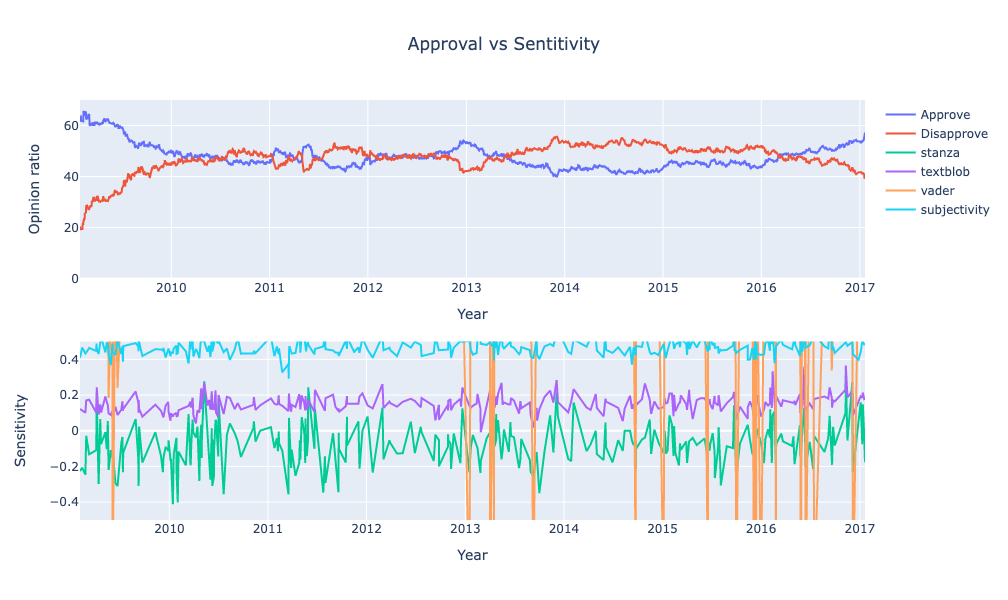

In [10]:
# Plot sentiment plus ratings


# Create figure with secondary y-axis
all_fig = make_subplots(rows=2, cols=1)

# Add popularity lines
for col in df_ppl.columns[1:]:
    all_fig.add_trace(go.Scatter(x=df_ppl["date"],
                      y=df_ppl[col], name=col),
                      row=1, col=1)

# Add sensitivity lines
for col in df_sa.columns[2:]:
    all_fig.add_trace(go.Scatter(x=df_sa["date"],
                      y=df_sa[col], name=col),
                      row=2,col=1)

# Add figure title
all_fig.update_layout(height=600, width=1450,
    title = {"text":"Approval vs Sentitivity", "x":0.5})

# Set x-axis title
all_fig.update_xaxes(title_text="Year")
all_fig.update_yaxes(title_text="Opinion ratio",range=[0,70], row=1, col=1)
all_fig.update_yaxes(title_text="Sensitivity",range=[-0.5,0.5], row=2, col=1)

all_fig.show()

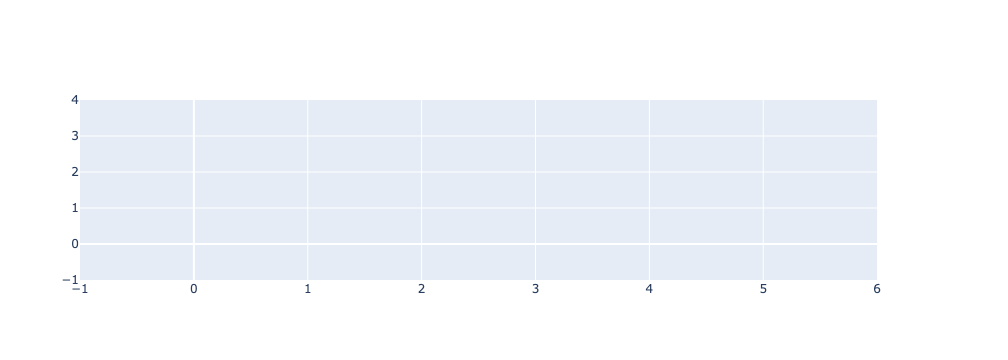

In [11]:
# Graph frequency vs sentiment

fq_fig = make_subplots(specs=[[{"secondary_y": True}]])



fq_fig.show()